In [1]:
import utils
import re
import numpy as np
from collections import namedtuple, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
from time import sleep

# Day 12: Subterranean Sustainability

The year 518 is significantly more underground than your history books implied. Either that, or you've arrived in a vast cavern network under the North Pole.

After exploring a little, you discover a long tunnel that contains a row of small pots as far as you can see to your left and right. A few of them contain plants - someone is trying to grow things in these geothermally-heated caves.

The pots are numbered, with 0 in front of you. To the left, the pots are numbered -1, -2, -3, and so on; to the right, 1, 2, 3.... Your puzzle input contains a list of pots from 0 to the right and whether they do (#) or do not (.) currently contain a plant, the initial state. (No other pots currently contain plants.) For example, an initial state of `#..##....` indicates that pots 0, 3, and 4 currently contain plants.

Your puzzle input also contains some notes you find on a nearby table: someone has been trying to figure out how these plants spread to nearby pots. Based on the notes, for each generation of plants, a given pot has or does not have a plant based on whether that pot (and the two pots on either side of it) had a plant in the last generation. These are written as LLCRR => N, where L are pots to the left, C is the current pot being considered, R are the pots to the right, and N is whether the current pot will have a plant in the next generation. For example:

- A note like `..#.. => .` means that a pot that contains a plant but with no plants within two pots of it will not have a plant in it during the next generation.
- A note like `##.## => .` means that an empty pot with two plants on each side of it will remain empty in the next generation.
- A note like `.##.# => #` means that a pot has a plant in a given generation if, in the previous generation, there were plants in that pot, the one immediately to the left, and the one two pots to the right, but not in the ones immediately to the right and two to the left.

It's not clear what these plants are for, but you're sure it's important, so you'd like to make sure the current configuration of plants is sustainable by determining what will happen after 20 generations.

For example, given the following input:

```
initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #
```

For brevity, in this example, only the combinations which do produce a plant are listed. (Your input includes all possible combinations.) Then, the next 20 generations will look like this:

```
                 1         2         3     
       0         0         0         0     
 0: ...#..#.#..##......###...###...........
 1: ...#...#....#.....#..#..#..#...........
 2: ...##..##...##....#..#..#..##..........
 3: ..#.#...#..#.#....#..#..#...#..........
 4: ...#.#..#...#.#...#..#..##..##.........
 5: ....#...##...#.#..#..#...#...#.........
 6: ....##.#.#....#...#..##..##..##........
 7: ...#..###.#...##..#...#...#...#........
 8: ...#....##.#.#.#..##..##..##..##.......
 9: ...##..#..#####....#...#...#...#.......
10: ..#.#..#...#.##....##..##..##..##......
11: ...#...##...#.#...#.#...#...#...#......
12: ...##.#.#....#.#...#.#..##..##..##.....
13: ..#..###.#....#.#...#....#...#...#.....
14: ..#....##.#....#.#..##...##..##..##....
15: ..##..#..#.#....#....#..#.#...#...#....
16: .#.#..#...#.#...##...#...#.#..##..##...
17: ..#...##...#.#.#.#...##...#....#...#...
18: ..##.#.#....#####.#.#.#...##...##..##..
19: .#..###.#..#.#.#######.#.#.#..#.#...#..
20: .#....##....#####...#######....#.#..##.
```

The generation is shown along the left, where 0 is the initial state. The pot numbers are shown along the top, where 0 labels the center pot, negative-numbered pots extend to the left, and positive pots extend toward the right. Remember, the initial state begins at pot 0, which is not the leftmost pot used in this example.

After one generation, only seven plants remain. The one in pot 0 matched the rule looking for ..#.., the one in pot 4 matched the rule looking for .#.#., pot 9 matched .##.., and so on.

In this example, after 20 generations, the pots shown as # contain plants, the furthest left of which is pot -2, and the furthest right of which is pot 34. Adding up all the numbers of plant-containing pots after the 20th generation produces 325.

**After 20 generations, what is the sum of the numbers of all pots which contain a plant?**

First up, grabbing the input and test inputs:

In [146]:
inp = utils.get_input(12).splitlines()
inp[:10]

['initial state: #...#####.#..##...##...#.##.#.##.###..##.##.#.#..#...###..####.#.....#..##..#.##......#####..####...',
 '',
 '#.#.# => #',
 '..### => .',
 '#..#. => #',
 '.#... => #',
 '..##. => #',
 '##.#. => #',
 '##..# => #',
 '####. => #']

In [147]:
test_inp = """initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #""".splitlines()

Now a function to parse the inputs into the start and the rules which apply:

In [150]:
def parse(inp=test_inp):
    start = inp[0].split(": ")[1]
    
    # dict defaults to off as I'm only storing the on rules in it
    rules = defaultdict(lambda: ".") 
    
    for rule in inp[2:]:
        r, result = rule.split(" => ")
        rules[r] = result
        
    return start, rules
    
test_start, test_rules = parse()
print("starting state: :" , test_start)
test_rules

starting state: : #..#.#..##......###...###


defaultdict(<function __main__.parse.<locals>.<lambda>()>,
            {'...##': '#',
             '..#..': '#',
             '.#...': '#',
             '.#.#.': '#',
             '.#.##': '#',
             '.##..': '#',
             '.####': '#',
             '#.#.#': '#',
             '#.###': '#',
             '##.#.': '#',
             '##.##': '#',
             '###..': '#',
             '###.#': '#',
             '####.': '#'})

So now we have the start state as a str, and a dict of the rules.

Now to put this together:

In [200]:
def sim(state=test_start, rules=test_rules, cycles=1, show=False):
    """takes in a state and rules and simulates the number of cycles
    then returns all the states"""
    
    grid = []
    
    state = "..." + state + ".." + "." * cycles
    grid.append(state)
    
    for cycle in range(cycles):
        new_state = ".."
        for i in range(2, len(state)-2):
            #print(i-2,i,i+2, state[i-2:i+3], "|", state[i])
            
            new_state += rules[state[i-2:i+3]]
            
        state = new_state + ".."
        grid.append(state)
        
        if show:
            plants = sum([i-3 for i, plant in enumerate(state) if plant == "#"])
            print(f"{cycle+1:2}: {state[:70]}  Sum: {plants}")
        
    return grid

test_grid = sim(cycles=20, show=True)

 1: ...#...#....#.....#..#..#..#......................  Sum: 91
 2: ...##..##...##....#..#..#..##.....................  Sum: 132
 3: ..#.#...#..#.#....#..#..#...#.....................  Sum: 102
 4: ...#.#..#...#.#...#..#..##..##....................  Sum: 154
 5: ....#...##...#.#..#..#...#...#....................  Sum: 115
 6: ....##.#.#....#...#..##..##..##...................  Sum: 174
 7: ...#..###.#...##..#...#...#...#...................  Sum: 126
 8: ...#....##.#.#.#..##..##..##..##..................  Sum: 213
 9: ...##..#..#####....#...#...#...#..................  Sum: 138
10: ..#.#..#...#.##....##..##..##..##.................  Sum: 213
11: ...#...##...#.#...#.#...#...#...#.................  Sum: 136
12: ...##.#.#....#.#...#.#..##..##..##................  Sum: 218
13: ..#..###.#....#.#...#....#...#...#................  Sum: 133
14: ..#....##.#....#.#..##...##..##..##...............  Sum: 235
15: ..##..#..#.#....#....#..#.#...#...#...............  Sum: 149
16: ...#..#...#.#...##...#

In [198]:
start, rules = parse(inp)
grid = sim(start, rules, cycles=20, show=True)

 1: ..#.#...#####...###..###.##...##...#.#.#.#.#..##...#.#...#.#..####.#..  Sum: 2253
 2: ..#..#...###.#...#.#..###.##..###.##.#.#.#....###.##..#.##.....####.#.  Sum: 2350
 3: ....#.#...###.#.##.....###.##..###..##.#..#....###.####..##.....#####.  Sum: 2327
 4: ...##..#...####..##.....###.##..#.#.#.#..#.#....###.##.#.###.....#####  Sum: 2341
 5: ...####.#...##.#.###.....###.####.#.#...##..#....###..##..#.#.....###.  Sum: 2408
 6: ....####.#..#.##..#.#.....###.#####..#..####.#....#.#.#####..#.....###  Sum: 2676
 7: .....####..##..####..#.....###.###.##....####.#..##.#..###.##.#.....##  Sum: 2743
 8: ......##.#.###..##.##.#.....###.###.##....####...#.#....###..#.#.....#  Sum: 2756
 9: ......#.##..#.#.#.#..#.#.....###.###.##....##.#.##..#....#.###..#....#  Sum: 2693
10: .....##..####.#.#...##..#.....###.###.##...#.##..###.#..##..#.##.#..##  Sum: 2843
11: .....###..#####..#..####.#.....###.###.##.##..##..###...#####...#...##  Sum: 3123
12: ......#.#..###.##....####.#.....###.###..#.##.###.

`3337` is the answer to part 1, but with a longer starting state the display is messy and doesn't display the entire state... so here goes a better version:

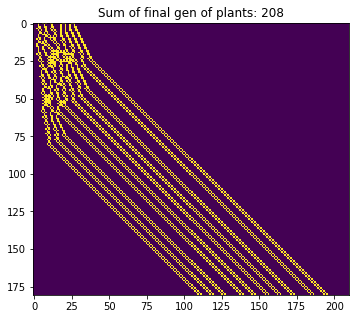

In [276]:
def show(states, ax=None):
    """takes in a list of states and shows it visually"""
    grid = [[c == "#" for c in k] for k in states]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(13,5))
    ax.set_title(f"test")
    ax.imshow(grid) # cmap=plt.get_cmap("RdBu")
    
    bbox_props = dict(boxstyle="round,pad=0", fc="black", ec="white", lw=0)
    #for i, state in enumerate(states):
    #    plants = sum([i-3 for i, plant in enumerate(state) if plant == "#"])
    #    ax.annotate(str(plants), (0.1,i+0.5), size=9, color="white", bbox=bbox_props)
    ax.set_title(f"Sum of final gen of plants: {plants}")

show(grid)

# Part 2

**After fifty billion (50000000000) generations, what is the sum of the numbers of all pots which contain a plant?**

So thats huge number to simulate, so hopefully there must be a pattern which repeats, as my solution above is pretty slow.

So I'm going to modify the above to see if there is a repeating pattern:

In [296]:
def sim2(state=test_start, rules=test_rules, cycles=1, show=False):
    """takes in a state and rules and simulates the number of cycles
    then returns all the states"""
    
    grid = []
    counts = []
    plants = sum([i-3 for i, plant in enumerate(state) if plant == "#"])
    counts.append(plants)
    
    state = "..." + state + ".." + "." * cycles
    grid.append(state)
    
    for cycle in range(cycles):
        new_state = ".."
        for i in range(2, len(state)-2):
            #print(i-2,i,i+2, state[i-2:i+3], "|", state[i])
            
            new_state += rules[state[i-2:i+3]]
            
        state = new_state + ".."
        grid.append(state)
        
        plants = sum([i-3 for i, plant in enumerate(state) if plant == "#"])
        
        counts.append(plants)
        
        if show:
            print(f"{cycle+1:2}: {state[:70]}  Sum: {plants}")
        
    return grid, counts

grid, counts = sim2(cycles=90)

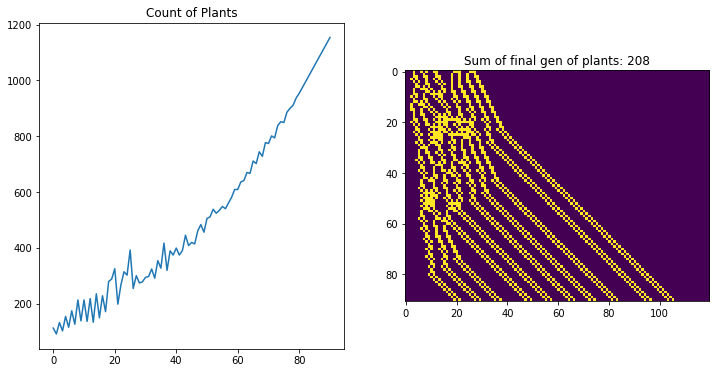

In [289]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(counts)
ax1.set_title("Count of Plants")
show(grid, ax2)